In [ ]:
#imports
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import matplotlib
#necessary for plotly interactivity. dont ask me why
matplotlib.use('nbagg')
import numpy as np
import scipy as sp
from scipy import sparse
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#from scipy import special
from random import gauss
#import hdf5storage
import h5py
import timeit
from numba import jit
#from sympy.solvers.solveset import nonlinsolve
#from sympy.core.symbol import symbols
#from sympy import exp
from scipy import stats
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from core.analysis import *
from core.simulation import *

In [ ]:
#this function reconstruct some necessary fiber properties from the 'Fibers' and saves them to file
#note that the function is set to utilize the data in 'fgCC', following selen's instruction
#however, another fiber dataset is present inside 'Fibers', called 'fg'.
#the other dataset can be selected manually from inside the function
construct_fibers_from_data(
                #data from Selen Atasoy
                filepath_data='G:/Macbook Stuff/Downloads/NeuralFieldModelv2/100307_Laplace.mat',
                filepath_Fibers='G:/Macbook Stuff/Downloads/Fibers.mat',
                           
                savefiles=True,
                bundle_size=7,
                output_filepath_fiber_edges='G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fg_fiber_bundles.npy',
                output_filepath_fiber_lengths='G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fg_fiber_lengths.npy',                       
                output_filepath_fiber_dist_starts='G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fg_fiber_dist_starts.npy',
                output_filepath_fiber_dist_ends='G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fg_fiber_dist_ends.npy',
                output_filepath_fiber_ends='G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fg_fiber_ends.npy')    

In [ ]:
#this function reconstruct the mesh + DTI adjacency directly from the 'faces' and 'fibers' datasets
#the subcortical nodes and edges are excluded at the end of the procedure
#if the 'visual' option is selected, the function also returns datasets in suitable format for plotly
mesh_DTI_adjacency, Xn, Yn, Zn, iN, jN, kN,  Xe, Ye, Ze = construct_adjacency_matrix_from_data(
                                #data from Selen Atasoy
                                filepath_data='G:/Macbook Stuff/Downloads/NeuralFieldModelv2/100307_Laplace.mat',
                                
                                #results of previous cell
                                filepath_fiber_edges=['G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fgCC_fiber_edges.npy'],#,'G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fg_fiber_edges.npy'],
                                filepath_fiber_lengths=['G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fgCC_fiber_lengths.npy'],#,'G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fg_fiber_lengths.npy'],
                                filepath_fiber_ends=['G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fgCC_fiber_ends.npy'],#,'G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fg_fiber_ends.npy'],
                                
                                include_subcortex=False,
                                add_DTI=True,
                                fiber_speed_factor=200,
    
                                threshold=False,
                                max_dist=10,
                                filepath_fiber_dist_starts=['G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fgCC_fiber_dist_starts.npy'],#,'G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fg_fiber_dist_starts.npy'],
                                filepath_fiber_dist_ends=['G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fgCC_fiber_dist_ends.npy'],#,'G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fg_fiber_dist_ends.npy'],

                                visual=True,
                                plot_subcortex=False,
                                plot_DTI_edges=False)

In [ ]:
#len(np.nonzero(mesh_DTI_adjacency.toarray())[0])/2
#np.shape(mesh_DTI_adjacency.toarray())
f = h5py.File('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/100307_Laplace.mat', 'r')
CC = np.asarray(f['CC']['restInds'], dtype=int)
indices = np.array([elem[0] for elem in CC])-1
AllVet=np.asarray(f['vertices']['all'])

u_0=np.heaviside(AllVet[0,indices],0)

#no_sub=mesh_DTI_adjacency[indices,:]
#no_sub=no_sub[:,indices]
#len(np.nonzero(no_sub.toarray())[0])/2
#mesh_DTI_adjacency=np.load('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/metric_cortical_DTI_bundles_full_all_fibers.npy')
#mesh_DTI_adjacency=mesh_DTI_adjacency[indices,:]
#mesh_DTI_adjacency=mesh_DTI_adjacency[:,indices]
#mesh_DTI_adjacency.toarray().shape

In [ ]:
#np.save('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/metric_cortical_DTI_bundles_full_all_fibers.npy', mesh_DTI_adjacency)

In [ ]:
#construct graph Laplacian and diagonalize it
#this is the same procedure used for regular graphs
AdjMatrix=mesh_DTI_adjacency.toarray()
AdjMatrix*=1000000
Deg=np.sum(AdjMatrix, axis=0)
Degree_Matrix=sp.sparse.diags(Deg)
regLap = Degree_Matrix - sp.sparse.csc_matrix(AdjMatrix)
Laplacian=-regLap.toarray()

vecs=True

if vecs==False:    
    eigenvalues=np.linalg.eigvalsh(Laplacian)
    eigenvalues[-1]=0
    eigenvalues=eigenvalues[::-1]
    np.save('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvals_DTI_full_200short.npy', eigenvalues)
else:
    eigenvalues,eigenvectors=np.linalg.eigh(Laplacian)
    #eigenvalues[-1]=0
    #note that the eigenvectors come out 2-normalized
    eigenvalues=eigenvalues[::-1]
    eigenvectors=eigenvectors[:,::-1]
    np.save('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvals_DTI_fgCC_200short_metres.npy', eigenvalues)
    np.save('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvecs_DTI_fgCC_200short_metres.npy', eigenvectors)


In [ ]:
#Alternatively, if previously known, read eigenvalues and eigenvectors from file
#this is what i used for the thesis. note that it has to be loaded with a minus sign
#eigenvalues_thesis = -np.load('E:/My Documents/Dropbox/Amsterdam Math/Rikkert Hindriks/Graph-Stochastic-Wilson-Cowan-Model/data/eigvals.npy')
#this should be the corresponding eigenvectors. they appear to be 1-normalized
#eigenvectors_thesis = -np.load('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvecs.npy')


#eigenvalues = np.load('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvals_DTI_fgCC_200short.npy')
eigenvalues = np.load('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvals_DTI_fgCC_200short_metres.npy')
#eigenvectors = np.load('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvecs_DTI_fgCC_200short_metres.npy')
#eigenvalues = -np.load('E:/My Documents/Dropbox/Amsterdam Math/Rikkert Hindriks/Graph-Stochastic-Wilson-Cowan-Model/data/eigvals.npy')
len(eigenvalues)
#np.save('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvals_DTI_fgCC_200short_metres.npy', eigenvalues)
#print(eigenvalues)
#print(eigenvalues2)

In [ ]:
#Set parameters and bounds for minimization algorithms
aEE, bnds_aEE = 140, (1e-15,1e15)
aIE, bnds_aIE = 155, (1e-15,1e15)
aEI, bnds_aEI = 165, (1e-15,1e15)
aII, bnds_aII = 140, (1e-15,1e15)
dE, bnds_dE = 2, (1e-15,1e15)
dI, bnds_dI = 2, (1e-15,1e15)
P, bnds_P = 0, (0,1e15)
Q, bnds_Q = 0, (0,1e15)
sEE, bnds_sEE = 6, (1e-15,1e15)
sIE, bnds_sIE = 10, (1e-15,1e15)
sEI, bnds_sEI = 10, (1e-15,1e15)
sII, bnds_sII = 50, (1e-15,1e15)
D, bnds_D = 1, (0.1,10)             #unchanged
tE, bnds_tE = 1, (1e-15,1e15)          
tI, bnds_tI = 1, (1e-15,1e15)          
#snE, bnds_snE = 1, (1,10)        #unchanged
#snI, bnds_snI = 1, (1,10)         #unchanged


initial_guess=np.array([aEE,aIE,aEI,aII,dE,dI,P,Q,sEE,sIE,sEI,sII,tE,tI])#,snE])#,snI]) 
bnds=[bnds_aEE,bnds_aIE,bnds_aEI,bnds_aII,bnds_dE,bnds_dI,bnds_P,bnds_Q,bnds_sEE,bnds_sIE,bnds_sEI,bnds_sII,bnds_tE,bnds_tI]#,bnds_snE]#,bnds_snI]

Graph_Kernel='Gaussian'

#thesis values
first_k=2
last_k=5000
thesis_spatial_spectrum = 15*(np.arange(first_k,last_k)**(-0.3))

first_k=3
last_k=len(eigenvalues)
x_t = np.log(np.arange(first_k,last_k))
new_spatial_spectrum = 10**(-0.012*x_t**(2.2) + 0.6 + 0.5*x_t**(-0.3))#0.02*x_t**(1.1)+1.1)# + x_t**(-1.5)+10)

#more similar to fluctuations power data from selen
new_spatial_spectrum = 10**(-0.018*x_t**(2.2) + 0.5 + 0.5*x_t**(-0.3))

True_Spatial_Spectrum = new_spatial_spectrum**2

plt.ion()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Spatial Power Spectrum  $P(k)$")
ax.set_xlabel("Spatial Eigenmode ($k$)")
ax.loglog(np.arange(first_k,last_k), True_Spatial_Spectrum)
         


LSA=True
Visual=False
SaveFiles=False
FilePath=' '

Min_omega=5*(2*np.pi)
Max_omega=50*(2*np.pi)
Delta_omega=0.1*(2*np.pi)

freqs=np.arange(Min_omega,Max_omega,Delta_omega)/(2*np.pi)

#higher gaussian TPS
higher_gaussian_TPS=100000/(100*freqs+10000)+5*np.exp((-(freqs-10)**2)/(2*0.9**2))
#lower gaussian TPS
lower_gaussian_TPS=100000/(100*freqs+10000)+3*np.exp((-(freqs-10)**2)/(2*1.2**2)) #too complex: 10*(1/(0.1*freqs+0.4)+0.7*np.exp((-(freqs-10)**2)/(2*0.9**2))+0.3*np.exp((-(freqs-22)**2)/(2*3**2)))
#even lower gaussian TPS
even_lower_gaussian_TPS=100000/(100*freqs+10000)+1.5*np.exp((-(freqs-10)**2)/(2*1.8**2))
#lowest gaussian TPS
lowest_gaussian_TPS=100000/(100*freqs+10000)+0.5*np.exp((-(freqs-10)**2)/(2*2.5**2))
#no gaussian TPS
no_gaussian_TPS=100000/(100*freqs+10000)

#new TPS, inspired by ketamine paper. suitable for loglog plotting, so multiplicative factor
new_TPS=2.5*freqs**(-1.25)+1.2*np.exp((-(freqs-10)**2)/(2*0.7**2)) + 0.06*np.exp((-(freqs-20)**2)/(2*0.7**2))
new_TPS[np.where((freqs>20) & (freqs<=40))] = 35*freqs[np.where((freqs>20) & (freqs<=40))]**(-2.17) +0.06*np.exp((-(freqs[np.where((freqs>20) & (freqs<=40))]-20)**2)/(2*0.7**2))
new_TPS[np.where(freqs>40)] = 1.17*freqs[np.where(freqs>40)]**(-1.25)

#empirical TPS from Rikkert MEG data
import scipy.io
MEG_PS_data = scipy.io.loadmat('MEG_powerspectrum.mat')
freqs = MEG_PS_data['f'][1:][:,0]
empirical_TPS = MEG_PS_data['p'].T[1:][:,0] * 10 **27
Min_omega=1*(2*np.pi)
Max_omega=40*(2*np.pi)
Delta_omega=0.5*(2*np.pi)
True_Temporal_Spectrum=empirical_TPS#[int(len(new_TPS)*0.1):int(len(new_TPS)*0.5)]
#Max_omega=25*(2*np.pi)


fig2 = plt.figure()
ax = fig2.add_subplot(111)
ax.set_title("Temporal Power Spectrum ")
ax.set_xlabel("Frequency (hz)")
ax.loglog(freqs, True_Temporal_Spectrum)

#change none to True_Spatial_Spectrum if want to fit to both
Args = (eigenvalues, Graph_Kernel, True_Temporal_Spectrum, Min_omega, Max_omega, Delta_omega, True_Spatial_Spectrum, first_k, LSA, Visual, SaveFiles)

In [ ]:
############################
#single analysis for easy visualization (note that if there are multiple stedy states the visualization will refer to the best one)
better_result=dict(x=np.array([1.15357519e+02, 1.80816514e+02, 1.89765888e+02, 2.10306805e+02,
       1.43682388e+01, 1.09130331e+00, 5.36635639e+00, 5.31252166e+00,
       8.37626732e+00, 2.74681544e+00, 3.66503548e-02, 1.00910684e+02,
       4.95497870e+00, 4.47579295e+00]))

aEE=115
aIE=175
aEI=190 
aII=210
dE=2.5 
dI=1 
P=0 
Q=0 
sEE=5.5 
sIE=3
sEI=3.5 
sII=100 
tE=1.2
tI=0.8
initial_guess=np.array([aEE,aIE,aEI,aII,dE,dI,P,Q,sEE,sIE,sEI,sII,tE,tI])
Full_Analysis(better_result['x'], eigenvalues, Graph_Kernel, True_Temporal_Spectrum, Max_omega, Delta_omega, True_Spatial_Spectrum, first_k, LSA, Visual, SaveFiles)

In [35]:
############################
#simple attempt at power spectrum fitting with a minimization algorithm. May get stuck in local minima.
#playing around with tolerance and max number of iterations is often necessary, depending on initial conditions. e.g.
#First run with fairly random initial guess: tol=1e-03, no maxiter (will take a while)
#Run starting from a previously obtained result: tol=1e-08, 'maxiter':2000

initial_guess=better_result['x']#np.load('decent_spatiotemporal_spectrum_lower_gauss.npy')[()]

result = sp.optimize.minimize(Full_Analysis, initial_guess, args=Args,
                              method='trust-constr', 
                              bounds=bnds, 
                              tol=1e-16,
                              options={#'ftol':1e-17,
                                          'maxiter': 2000,
                                       'disp':True})

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.97, scale: *113.2. +-5.044 
Dist temporal: 0.8207, scale: *1.404 +-2.705

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.97, scale: *113.2. +-5.044 
Dist temporal: 0.8207, scale: *1.404 +-2.705

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.97, scale: *113.2. +-5.044 
Dist temporal: 0.8207, scale: *1.404 +-2.705

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.97, scale: *113.2. +-5.044 
Dist temporal: 0.8207, scale: *1.404 +-2.705

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist s

Best suitable steady state: 0, with Ess=0.007099 Iss=0.06509.
Dist spatial: 60.95, scale: *2.328e+09. +-1.385e+07 
Dist temporal: 7.8, scale: *1.838 +-1.943

E*=0.0071, I*=0.0651: strictly stable
Best suitable steady state: 0, with Ess=0.007099 Iss=0.06509.
Dist spatial: 61.82, scale: *2.259e+09. +-1.344e+07 
Dist temporal: 7.8, scale: *1.838 +-1.943

E*=0.0071, I*=0.0651: strictly stable
Best suitable steady state: 0, with Ess=0.007099 Iss=0.06509.
Dist spatial: 61.82, scale: *2.259e+09. +-1.344e+07 
Dist temporal: 7.8, scale: *1.838 +-1.943

E*=0.0071, I*=0.0651: strictly stable
Best suitable steady state: 0, with Ess=0.007099 Iss=0.06509.
Dist spatial: 61.33, scale: *2.293e+09. +-1.364e+07 
Dist temporal: 7.8, scale: *1.838 +-1.943

E*=0.0071, I*=0.0651: strictly stable
Best suitable steady state: 0, with Ess=0.007099 Iss=0.06509.
Dist spatial: 62.39, scale: *2.226e+09. +-1.324e+07 
Dist temporal: 7.8, scale: *1.838 +-1.943

E*=0.0071, I*=0.0651: strictly stable
Best suitable steady

E:\Users\Marco1\Anaconda3\envs\py37\lib\site-packages\scipy\optimize\_differentiable_functions.py:139: RuntimeWarning: invalid value encountered in subtract
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Best suitable steady state: 0, with Ess=0.007099 Iss=0.06509.
Dist spatial: 62.67, scale: *2.395e+09. +-1.425e+07 
Dist temporal: 7.8, scale: *1.838 +-1.943

E*=0.0071, I*=0.0651: strictly stable
Best suitable steady state: 0, with Ess=0.007099 Iss=0.06509.
Dist spatial: 62.69, scale: *2.434e+09. +-1.448e+07 
Dist temporal: 7.8, scale: *1.838 +-1.943

E*=0.0071, I*=0.0651: strictly stable
Best suitable steady state: 0, with Ess=0.007099 Iss=0.06509.
Dist spatial: 63.2, scale: *2.515e+09. +-1.496e+07 
Dist temporal: 7.8, scale: *1.838 +-1.943

E*=0.0071, I*=0.0651: strictly stable
Best suitable steady state: 0, with Ess=0.007099 Iss=0.06509.
Dist spatial: 62.79, scale: *2.358e+09. +-1.402e+07 
Dist temporal: 7.8, scale: *1.838 +-1.943

E*=0.0071, I*=0.0651: strictly stable
Best suitable steady state: 0, with Ess=0.007099 Iss=0.06509.
Dist spatial: 62.69, scale: *2.434e+09. +-1.448e+07 
Dist temporal: 7.8, scale: *1.838 +-1.943

E*=0.0071, I*=0.0651: strictly stable
Best suitable steady 

In [32]:
############################
#more complicated fitting attempt with basinhopping stochastic minimization
#to obtain good results in sensible amounts of time, playing with minimization parameters is required
#the relevant parameter are again tolerance and maxiter, similarly to above (which affect the local minimization loop)
#but also niter and stepsize. these specify how many local minimizations we wish to carry out, 
#and the size of the basin-hopping random step inbetween local minimizations



#best temporal spectrum
#new_initial_guess=result['x']

#best spatial spectrum (thesis)
#old_initial_guess=np.array([1.15357519e+02, 1.80816514e+02, 1.89765888e+02, 2.10306805e+02,
#       1.43682388e+01, 1.09130331e+00, 5.36635639e+00, 5.31252166e+00,
#       8.37626732e+00, 2.74681544e+00, 3.66503548e-02, 1.00910684e+02,
#       4.95497870e+00, 4.47579295e+00])

new_initial_guess=better_result['x']

#sort of ugly, but need to defind bounds manually for basinhopping
class MyBounds(object):
    def __init__(self, xmax=[elem[1] for elem in bnds], xmin=[elem[0] for elem in bnds]):#, hello=this_temporal_distance):
        self.xmax = np.array(xmax)
        self.xmin = np.array(xmin)
        #self.hello = hello
    def __call__(self, **kwargs):
        x = kwargs["x_new"]
        tmax = bool(np.all(x <= self.xmax))
        tmin = bool(np.all(x >= self.xmin))
        t=tmax and tmin
        
        New_Dist=Full_Analysis(x, eigenvalues, Graph_Kernel, True_Temporal_Spectrum, Min_omega, Max_omega, Delta_omega, True_Spatial_Spectrum, first_k, LSA, Visual, SaveFiles)
        
        success = New_Dist<900.0
        
        #if t and success and New_Dist<self.hello:
        #    self.hello=New_Dist
        #    new_initial_guess=np.copy(x)
        
        return t and success
    
    
    #potential TODO: only accept parameter sets that return stable positive steady states (actually no: they might be locally near a suitable state. still worth to do local minimization)

#minimizer_kwargs={'args':Args, 'method':'TNC', 'bounds':bnds, 'tol':1e-03, 'options':{'maxiter':500}}


def custom_min(fun, x0, args, **kwargs):
    Bounds=bnds
    #Bounds[0:8]=[(elem,elem) for elem in x0[0:8]]
     
     
    result = sp.optimize.minimize(fun,x0,args=Args, method='L-BFGS-B', bounds=Bounds,
                                #tol=1e-16,
                                options={'maxiter':2000, 
                                         'ftol': 1e-16,
                                         'maxls': 100,
                                         'disp':True})
    print(result)
    
    return result


better_result = sp.optimize.basinhopping(Full_Analysis, new_initial_guess, niter=1, stepsize=5,
                                  minimizer_kwargs=dict(method=custom_min),
                                  accept_test=MyBounds(), disp=True)

#Init=np.stack((new_initial_guess,new_initial_guess,new_initial_guess,new_initial_guess,new_initial_guess,better_result['x'],better_result['x'],better_result['x'],better_result['x']))
#better_result = sp.optimize.differential_evolution(Full_Analysis, bounds=bnds, args=Args, tol=1e-10, disp=True, init=Init)


E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *113.2. +-5.108 
Dist temporal: 0.817, scale: *1.395 +-2.687

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *113.2. +-5.108 
Dist temporal: 0.817, scale: *1.395 +-2.687

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *113.2. +-5.108 
Dist temporal: 0.817, scale: *1.395 +-2.687

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *113.2. +-5.108 
Dist temporal: 0.817, scale: *1.395 +-2.687

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scal

Best suitable steady state: 0, with Ess=0.0001444 Iss=0.08025.
Dist spatial: 159.9, scale: *4.101e+05. +-103 
Dist temporal: 7.886, scale: *2.656 +0.486

E*=0.0001, I*=0.0803: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.0001444 Iss=0.08025.
Dist spatial: 159.9, scale: *4.101e+05. +-103 
Dist temporal: 7.886, scale: *2.656 +0.486

E*=0.0001, I*=0.0803: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.0001444 Iss=0.08025.
Dist spatial: 159.9, scale: *4.101e+05. +-103 
Dist temporal: 7.886, scale: *2.656 +0.486

E*=0.0001, I*=0.0803: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.0001444 Iss=0.08025.
Dist spatial: 159.9, scale: *4.101e+05. +-103 
Dist temporal: 7.886, scale: *2.656 +0.486

E*=0.0010, I*=0.0748: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.00095 Iss=0.07483.
Dist spatial: 120.4, scale: *3.148e+04. +-24.08 
Dist temporal: 8.0

E*=0.0045, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004512 Iss=0.07779.
Dist spatial: 16.54, scale: *159.9. +-5.031 
Dist temporal: 9.346, scale: *0.01322 +0.671

E*=0.0045, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004512 Iss=0.07779.
Dist spatial: 16.54, scale: *159.9. +-5.031 
Dist temporal: 9.346, scale: *0.01322 +0.671

E*=0.0045, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004512 Iss=0.07779.
Dist spatial: 16.54, scale: *159.9. +-5.031 
Dist temporal: 9.346, scale: *0.01322 +0.671

E*=0.0045, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004512 Iss=0.07779.
Dist spatial: 16.54, scale: *159.9. +-5.031 
Dist temporal: 9.346, scale: *0.01322 +0.671

E*=0.0045, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004512 Iss=0.07779.
Dist s


E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14.05, scale: *113.2. +-5.102 
Dist temporal: 0.8871, scale: *1.427 +-2.75

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14.05, scale: *113.2. +-5.102 
Dist temporal: 0.8871, scale: *1.427 +-2.75

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14.05, scale: *113.2. +-5.102 
Dist temporal: 0.8871, scale: *1.427 +-2.75

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14.05, scale: *113.2. +-5.102 
Dist temporal: 0.8871, scale: *1.427 +-2.75

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spat

Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *113.1. +-5.1 
Dist temporal: 0.8168, scale: *1.399 +-2.695

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *113.1. +-5.1 
Dist temporal: 0.8168, scale: *1.399 +-2.695

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *113.1. +-5.1 
Dist temporal: 0.8168, scale: *1.399 +-2.695

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *113.1. +-5.1 
Dist temporal: 0.8168, scale: *1.399 +-2.695

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *113.1. +-5.1 
Dist temporal: 0.8168, scale: *1.399 +-2.695

E*=0

Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *112.5. +-5.074 
Dist temporal: 0.8168, scale: *1.401 +-2.7

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *112.5. +-5.074 
Dist temporal: 0.8168, scale: *1.401 +-2.7

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *112.3. +-5.061 
Dist temporal: 0.8169, scale: *1.398 +-2.697

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *112.3. +-5.061 
Dist temporal: 0.8169, scale: *1.398 +-2.697

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *112.3. +-5.061 
Dist temporal: 0.8169, scale: *1.398 +-2.697

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *112.3. +-5.063 
Dist temporal: 0.8169, scale: *1.397 +-2.694

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *112.3. +-5.063 
Dist temporal: 0.8169, scale: *1.397 +-2.694

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *112.3. +-5.063 
Dist temporal: 0.8169, scale: *1.397 +-2.694

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *112.3. +-5.063 
Dist temporal: 0.8169, scale: *1.397 +-2.694

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, 

Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *112.4. +-5.068 
Dist temporal: 0.8169, scale: *1.399 +-2.697

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *112.4. +-5.068 
Dist temporal: 0.8169, scale: *1.399 +-2.697

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *112.4. +-5.068 
Dist temporal: 0.8169, scale: *1.399 +-2.697

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *112.4. +-5.068 
Dist temporal: 0.8169, scale: *1.399 +-2.697

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *112.4. +-5.068 
Dist temporal: 0.8169, scale: *1.399 +-2

Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *112.5. +-5.07 
Dist temporal: 0.8167, scale: *1.4 +-2.699

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *112.5. +-5.07 
Dist temporal: 0.8167, scale: *1.4 +-2.699

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *112.5. +-5.07 
Dist temporal: 0.8167, scale: *1.4 +-2.699

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *112.5. +-5.07 
Dist temporal: 0.8167, scale: *1.4 +-2.699

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *112.5. +-5.07 
Dist temporal: 0.8167, scale: *1.4 +-2.699

E*=0.0046

Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *112.1. +-5.052 
Dist temporal: 0.8166, scale: *1.398 +-2.697

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *112.1. +-5.052 
Dist temporal: 0.8166, scale: *1.398 +-2.697

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *112.1. +-5.052 
Dist temporal: 0.8166, scale: *1.398 +-2.697

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *112.1. +-5.052 
Dist temporal: 0.8166, scale: *1.398 +-2.697

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *112.1. +-5.052 
Dist temporal: 0.8166, scale: *1.398 +-2

Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *112. +-5.047 
Dist temporal: 0.8166, scale: *1.397 +-2.693

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *112. +-5.047 
Dist temporal: 0.8166, scale: *1.397 +-2.693

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *112. +-5.047 
Dist temporal: 0.8166, scale: *1.397 +-2.693

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *112. +-5.05 
Dist temporal: 0.8166, scale: *1.397 +-2.695

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *112. +-5.05 
Dist temporal: 0.8166, scale: *1.397 +-2.695

E*=0.0

Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *112. +-5.05 
Dist temporal: 0.8166, scale: *1.397 +-2.694

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *112. +-5.05 
Dist temporal: 0.8166, scale: *1.397 +-2.694

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *112. +-5.05 
Dist temporal: 0.8166, scale: *1.397 +-2.694

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *112. +-5.05 
Dist temporal: 0.8166, scale: *1.397 +-2.694

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *112. +-5.05 
Dist temporal: 0.8166, scale: *1.397 +-2.694

E*=0.0046

Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *112. +-5.051 
Dist temporal: 0.8166, scale: *1.397 +-2.694

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *112. +-5.051 
Dist temporal: 0.8166, scale: *1.397 +-2.694

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *112. +-5.051 
Dist temporal: 0.8166, scale: *1.397 +-2.694

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *112. +-5.051 
Dist temporal: 0.8166, scale: *1.397 +-2.694

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *112. +-5.051 
Dist temporal: 0.8166, scale: *1.397 +-2.694

E*=0

Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *112. +-5.048 
Dist temporal: 0.8166, scale: *1.397 +-2.694

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *112. +-5.048 
Dist temporal: 0.8166, scale: *1.397 +-2.694

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *112. +-5.048 
Dist temporal: 0.8166, scale: *1.397 +-2.694

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *112. +-5.048 
Dist temporal: 0.8166, scale: *1.397 +-2.694

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 14, scale: *112. +-5.048 
Dist temporal: 0.8166, scale: *1.397 +-2.694

E*=0

Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 13.99, scale: *111.7. +-5.032 
Dist temporal: 0.8168, scale: *1.397 +-2.696

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 13.99, scale: *111.7. +-5.032 
Dist temporal: 0.8168, scale: *1.397 +-2.696

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 13.99, scale: *111.7. +-5.032 
Dist temporal: 0.8168, scale: *1.397 +-2.696

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 13.99, scale: *111.7. +-5.032 
Dist temporal: 0.8168, scale: *1.397 +-2.696

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004553 Iss=0.07783.
Dist spatial: 13.99, scale: *111.7. +-5.032 
Dist temporal: 0.8168, sc

Best suitable steady state: 0, with Ess=0.004552 Iss=0.07783.
Dist spatial: 13.99, scale: *111.5. +-5.002 
Dist temporal: 0.8188, scale: *1.4 +-2.702

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07783.
Dist spatial: 13.99, scale: *111.5. +-5.002 
Dist temporal: 0.8188, scale: *1.4 +-2.702

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004551 Iss=0.0778.
Dist spatial: 13.95, scale: *111.9. +-4.9 
Dist temporal: 0.8425, scale: *1.428 +-2.763

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004551 Iss=0.0778.
Dist spatial: 13.95, scale: *111.9. +-4.9 
Dist temporal: 0.8425, scale: *1.428 +-2.763

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004551 Iss=0.0778.
Dist spatial: 13.95, scale: *111.9. +-4.9 
Dist temporal: 0.8425, scale: *1.428 +

Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *111.6. +-4.996 
Dist temporal: 0.8195, scale: *1.401 +-2.704

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *111.6. +-4.996 
Dist temporal: 0.8195, scale: *1.401 +-2.704

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *111.6. +-4.996 
Dist temporal: 0.8195, scale: *1.401 +-2.704

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *111.6. +-4.996 
Dist temporal: 0.8195, scale: *1.401 +-2.704

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *111.6. +-4.996 
Dist temporal: 0.8195, sc

Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *112.8. +-5.046 
Dist temporal: 0.8192, scale: *1.403 +-2.704

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *112.8. +-5.046 
Dist temporal: 0.8192, scale: *1.403 +-2.704

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *112.8. +-5.046 
Dist temporal: 0.8192, scale: *1.403 +-2.704

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *112.8. +-5.046 
Dist temporal: 0.8192, scale: *1.403 +-2.704

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *112.8. +-5.046 
Dist temporal: 0.8192, sc

Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *113.1. +-5.046 
Dist temporal: 0.8204, scale: *1.403 +-2.703

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *113.1. +-5.046 
Dist temporal: 0.8204, scale: *1.403 +-2.703

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *113.1. +-5.046 
Dist temporal: 0.8204, scale: *1.403 +-2.703

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *113.1. +-5.045 
Dist temporal: 0.8205, scale: *1.403 +-2.705

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *113.1. +-5.045 
Dist temporal: 0.8205, sc

Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *113.1. +-5.042 
Dist temporal: 0.8206, scale: *1.403 +-2.704

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *113.1. +-5.042 
Dist temporal: 0.8206, scale: *1.403 +-2.704

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *113.1. +-5.042 
Dist temporal: 0.8206, scale: *1.403 +-2.704

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *113.1. +-5.043 
Dist temporal: 0.8206, scale: *1.403 +-2.704

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *113.1. +-5.042 
Dist temporal: 0.8206, sc


E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *113.1. +-5.043 
Dist temporal: 0.8206, scale: *1.403 +-2.704

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *113.1. +-5.043 
Dist temporal: 0.8206, scale: *1.403 +-2.704

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *113.1. +-5.043 
Dist temporal: 0.8206, scale: *1.403 +-2.704

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *113.1. +-5.043 
Dist temporal: 0.8206, scale: *1.403 +-2.704

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist 

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *113.1. +-5.043 
Dist temporal: 0.8206, scale: *1.403 +-2.704

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *113.1. +-5.043 
Dist temporal: 0.8206, scale: *1.403 +-2.704

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *113.1. +-5.043 
Dist temporal: 0.8206, scale: *1.403 +-2.704

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *113.1. +-5.043 
Dist temporal: 0.8206, scale: *1.403 +-2.704

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist s

Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *113.1. +-5.043 
Dist temporal: 0.8206, scale: *1.403 +-2.704

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *113.1. +-5.043 
Dist temporal: 0.8206, scale: *1.403 +-2.704

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *113.1. +-5.043 
Dist temporal: 0.8206, scale: *1.403 +-2.704

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *113.1. +-5.043 
Dist temporal: 0.8206, scale: *1.403 +-2.704

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *113.1. +-5.043 
Dist temporal: 0.8206, sc

Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *113.1. +-5.043 
Dist temporal: 0.8206, scale: *1.403 +-2.704

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *113.1. +-5.043 
Dist temporal: 0.8206, scale: *1.403 +-2.704

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *113.1. +-5.043 
Dist temporal: 0.8206, scale: *1.403 +-2.704

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *113. +-5.043 
Dist temporal: 0.8204, scale: *1.403 +-2.704

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *113. +-5.043 
Dist temporal: 0.8204, scale:


E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *113.1. +-5.047 
Dist temporal: 0.8204, scale: *1.403 +-2.703

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *113.1. +-5.047 
Dist temporal: 0.8204, scale: *1.403 +-2.703

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *113.1. +-5.047 
Dist temporal: 0.8204, scale: *1.403 +-2.703

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *113.1. +-5.047 
Dist temporal: 0.8204, scale: *1.403 +-2.703

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist 


E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.97, scale: *113.1. +-5.046 
Dist temporal: 0.8225, scale: *1.399 +-2.696

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.97, scale: *113.1. +-5.046 
Dist temporal: 0.8225, scale: *1.399 +-2.696

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.97, scale: *113.1. +-5.046 
Dist temporal: 0.8225, scale: *1.399 +-2.696

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.97, scale: *113.1. +-5.046 
Dist temporal: 0.8225, scale: *1.399 +-2.696

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist 

Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *113.2. +-5.047 
Dist temporal: 0.8206, scale: *1.403 +-2.705

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *113.2. +-5.047 
Dist temporal: 0.8206, scale: *1.404 +-2.705

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *113.2. +-5.047 
Dist temporal: 0.8206, scale: *1.403 +-2.705

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *113.2. +-5.047 
Dist temporal: 0.8206, scale: *1.403 +-2.705

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.98, scale: *113.2. +-5.047 
Dist temporal: 0.8206, sc

Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.97, scale: *113.2. +-5.044 
Dist temporal: 0.8207, scale: *1.404 +-2.705

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.97, scale: *113.2. +-5.044 
Dist temporal: 0.8207, scale: *1.404 +-2.705

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.97, scale: *113.2. +-5.044 
Dist temporal: 0.8207, scale: *1.404 +-2.705

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.97, scale: *113.2. +-5.044 
Dist temporal: 0.8207, scale: *1.404 +-2.705

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.97, scale: *113.2. +-5.044 
Dist temporal: 0.8207, sc

Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.97, scale: *113.1. +-5.044 
Dist temporal: 0.8207, scale: *1.404 +-2.705

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.97, scale: *113.1. +-5.044 
Dist temporal: 0.8207, scale: *1.404 +-2.705

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.97, scale: *113.1. +-5.044 
Dist temporal: 0.8207, scale: *1.404 +-2.705

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.97, scale: *113.2. +-5.044 
Dist temporal: 0.8207, scale: *1.404 +-2.705

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.97, scale: *113.2. +-5.044 
Dist temporal: 0.8207, sc

Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.97, scale: *113.2. +-5.044 
Dist temporal: 0.8207, scale: *1.404 +-2.705

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.97, scale: *113.2. +-5.044 
Dist temporal: 0.8207, scale: *1.404 +-2.705

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.97, scale: *113.2. +-5.044 
Dist temporal: 0.8207, scale: *1.404 +-2.705

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.97, scale: *113.2. +-5.044 
Dist temporal: 0.8207, scale: *1.404 +-2.705

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.97, scale: *113.2. +-5.044 
Dist temporal: 0.8207, sc

Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.97, scale: *113.2. +-5.044 
Dist temporal: 0.8207, scale: *1.404 +-2.705

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.97, scale: *113.2. +-5.044 
Dist temporal: 0.8207, scale: *1.404 +-2.705

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.97, scale: *113.2. +-5.044 
Dist temporal: 0.8207, scale: *1.404 +-2.705

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.97, scale: *113.2. +-5.044 
Dist temporal: 0.8207, scale: *1.404 +-2.705

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.97, scale: *113.2. +-5.044 
Dist temporal: 0.8207, sc


E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.97, scale: *113.2. +-5.044 
Dist temporal: 0.8207, scale: *1.404 +-2.705

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.97, scale: *113.2. +-5.044 
Dist temporal: 0.8207, scale: *1.404 +-2.705

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.97, scale: *113.2. +-5.044 
Dist temporal: 0.8207, scale: *1.404 +-2.705

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.97, scale: *113.2. +-5.044 
Dist temporal: 0.8207, scale: *1.404 +-2.705

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist 

Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.97, scale: *113.2. +-5.044 
Dist temporal: 0.8207, scale: *1.404 +-2.705

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.97, scale: *113.2. +-5.044 
Dist temporal: 0.8207, scale: *1.404 +-2.705

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.97, scale: *113.2. +-5.044 
Dist temporal: 0.8207, scale: *1.404 +-2.705

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.97, scale: *113.2. +-5.044 
Dist temporal: 0.8207, scale: *1.404 +-2.705

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.004552 Iss=0.07782.
Dist spatial: 13.97, scale: *113.2. +-5.044 
Dist temporal: 0.8207, sc

Best suitable steady state: 0, with Ess=0.006959 Iss=0.09613.
Dist spatial: 196.2, scale: *1.512e+05. +-1.48e+06 
Dist temporal: 7.748, scale: *1.738e+05 +-3.4e+05

E*=0.0070, I*=0.0961: strictly stable
Best suitable steady state: 0, with Ess=0.006959 Iss=0.09613.
Dist spatial: 195.6, scale: *1.925e+05. +-1.883e+06 
Dist temporal: 7.748, scale: *1.738e+05 +-3.399e+05

E*=0.0070, I*=0.0961: strictly stable
Best suitable steady state: 0, with Ess=0.006959 Iss=0.09613.
Dist spatial: 196.2, scale: *1.512e+05. +-1.48e+06 
Dist temporal: 7.748, scale: *1.738e+05 +-3.399e+05

E*=0.0070, I*=0.0944: strictly stable
Best suitable steady state: 0, with Ess=0.006991 Iss=0.09437.
Dist spatial: 198.1, scale: *5.322e-10. +0.08639 
Dist temporal: 7.896, scale: *35.01 +-67.94

E*=0.0070, I*=0.0944: strictly stable
Best suitable steady state: 0, with Ess=0.006991 Iss=0.09437.
Dist spatial: 198.1, scale: *5.322e-10. +0.08639 
Dist temporal: 7.896, scale: *35.01 +-67.94

E*=0.0070, I*=0.0944: strictly sta

Best suitable steady state: 0, with Ess=0.006969 Iss=0.09562.
Dist spatial: 201.2, scale: *-1.132e+05. +1.563e+06 
Dist temporal: 7.864, scale: *5.406e+04 +-1.057e+05

E*=0.0070, I*=0.0956: strictly stable
Best suitable steady state: 0, with Ess=0.006969 Iss=0.09562.
Dist spatial: 201.2, scale: *-1.122e+05. +1.549e+06 
Dist temporal: 7.864, scale: *5.406e+04 +-1.057e+05

E*=0.0070, I*=0.0956: strictly stable
Best suitable steady state: 0, with Ess=0.006969 Iss=0.09562.
Dist spatial: 201.2, scale: *-1.132e+05. +1.563e+06 
Dist temporal: 7.864, scale: *5.406e+04 +-1.057e+05

E*=0.0070, I*=0.0956: strictly stable
Best suitable steady state: 0, with Ess=0.006969 Iss=0.09562.
Dist spatial: 201.2, scale: *-1.132e+05. +1.563e+06 
Dist temporal: 7.864, scale: *5.406e+04 +-1.057e+05

E*=0.0070, I*=0.0956: strictly stable
Best suitable steady state: 0, with Ess=0.006969 Iss=0.09562.
Dist spatial: 194.9, scale: *1.182e+05. +-1.632e+06 
Dist temporal: 7.864, scale: *5.406e+04 +-1.057e+05

E*=0.007

Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 135.8, scale: *3.203e+06. +-3.757e+07 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 135.8, scale: *3.203e+06. +-3.757e+07 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 135.8, scale: *3.203e+06. +-3.757e+07 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 135.8, scale: *3.203e+06. +-3.757e+07 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 106, scale: *4.805e+06. +-5.635e+07 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070,

Best suitable steady state: 0, with Ess=0.006968 Iss=0.09568.
Dist spatial: 191.3, scale: *2.76e+05. +-3.638e+06 
Dist temporal: 7.859, scale: *6.294e+04 +-1.231e+05

E*=0.0070, I*=0.0957: strictly stable
Best suitable steady state: 0, with Ess=0.006968 Iss=0.09568.
Dist spatial: 191.3, scale: *2.76e+05. +-3.638e+06 
Dist temporal: 7.859, scale: *6.294e+04 +-1.231e+05

E*=0.0070, I*=0.0957: strictly stable
Best suitable steady state: 0, with Ess=0.006968 Iss=0.09568.
Dist spatial: 193.4, scale: *1.897e+05. +-2.501e+06 
Dist temporal: 7.859, scale: *6.294e+04 +-1.231e+05

E*=0.0070, I*=0.0957: strictly stable
Best suitable steady state: 0, with Ess=0.006968 Iss=0.09568.
Dist spatial: 191.6, scale: *2.64e+05. +-3.48e+06 
Dist temporal: 7.859, scale: *6.294e+04 +-1.231e+05

E*=0.0070, I*=0.0957: strictly stable
Best suitable steady state: 0, with Ess=0.006968 Iss=0.09568.
Dist spatial: 191.3, scale: *2.76e+05. +-3.638e+06 
Dist temporal: 7.859, scale: *6.294e+04 +-1.231e+05

E*=0.0070, I*

Best suitable steady state: 0, with Ess=0.006965 Iss=0.09583.
Dist spatial: 202.9, scale: *-2.364e+05. +2.784e+06 
Dist temporal: 7.837, scale: *9.165e+04 +-1.793e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09583.
Dist spatial: 202.9, scale: *-2.364e+05. +2.784e+06 
Dist temporal: 7.837, scale: *9.165e+04 +-1.793e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09583.
Dist spatial: 202.9, scale: *-2.364e+05. +2.784e+06 
Dist temporal: 7.837, scale: *9.165e+04 +-1.792e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09583.
Dist spatial: 202.9, scale: *-2.364e+05. +2.784e+06 
Dist temporal: 7.837, scale: *9.165e+04 +-1.793e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09583.
Dist spatial: 202.9, scale: *-2.364e+05. +2.784e+06 
Dist temporal: 7.837, scale: *9.166e+04 +-1.793e+05

E*=0.007

Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 200.2, scale: *-1.023e+05. +1.201e+06 
Dist temporal: 7.836, scale: *9.278e+04 +-1.815e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 262.1, scale: *-3.207e+06. +3.762e+07 
Dist temporal: 7.836, scale: *9.277e+04 +-1.814e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 200.3, scale: *-1.069e+05. +1.254e+06 
Dist temporal: 7.836, scale: *9.277e+04 +-1.814e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 166.6, scale: *1.602e+06. +-1.879e+07 
Dist temporal: 7.836, scale: *9.288e+04 +-1.816e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 166.6, scale: *1.602e+06. +-1.879e+07 
Dist temporal: 7.836, scale: *9.288e+04 +-1.816e+05

E*=0.007

Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 210, scale: *-6.007e+05. +7.044e+06 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 210, scale: *-6.007e+05. +7.044e+06 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 210, scale: *-6.007e+05. +7.044e+06 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 210, scale: *-6.007e+05. +7.044e+06 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 194, scale: *2.089e+05. +-2.45e+06 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070, I*=0.095

Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 200.2, scale: *-1.056e+05. +1.238e+06 
Dist temporal: 7.836, scale: *9.293e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 200.2, scale: *-1.056e+05. +1.238e+06 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 200.2, scale: *-1.056e+05. +1.238e+06 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 200.2, scale: *-1.056e+05. +1.238e+06 
Dist temporal: 7.836, scale: *9.293e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 200.3, scale: *-1.068e+05. +1.252e+06 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.007

Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 193, scale: *2.597e+05. +-3.046e+06 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 193, scale: *2.597e+05. +-3.046e+06 
Dist temporal: 7.836, scale: *9.293e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 194.9, scale: *1.657e+05. +-1.943e+06 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 192.6, scale: *2.827e+05. +-3.315e+06 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 193, scale: *2.597e+05. +-3.046e+06 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070, I*=

Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 201.5, scale: *-1.686e+05. +1.977e+06 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 201.5, scale: *-1.686e+05. +1.977e+06 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 201.5, scale: *-1.686e+05. +1.977e+06 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 201.5, scale: *-1.686e+05. +1.977e+06 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 201.5, scale: *-1.686e+05. +1.977e+06 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.007

Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 135.8, scale: *3.203e+06. +-3.757e+07 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 206.8, scale: *-4.368e+05. +5.123e+06 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 183.6, scale: *7.392e+05. +-8.669e+06 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 135.8, scale: *3.203e+06. +-3.757e+07 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 135.8, scale: *3.203e+06. +-3.757e+07 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.007

Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 135.8, scale: *3.203e+06. +-3.757e+07 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 106, scale: *4.805e+06. +-5.635e+07 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 135.8, scale: *3.203e+06. +-3.757e+07 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 135.8, scale: *3.203e+06. +-3.757e+07 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 206.8, scale: *-4.368e+05. +5.123e+06 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070,

Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 135.8, scale: *3.203e+06. +-3.757e+07 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 135.8, scale: *3.203e+06. +-3.757e+07 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 135.8, scale: *3.203e+06. +-3.757e+07 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 135.8, scale: *3.203e+06. +-3.757e+07 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 106, scale: *4.805e+06. +-5.635e+07 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070,

Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 135.8, scale: *3.203e+06. +-3.757e+07 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 135.8, scale: *3.203e+06. +-3.757e+07 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 135.8, scale: *3.203e+06. +-3.757e+07 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 192.4, scale: *2.912e+05. +-3.415e+06 
Dist temporal: 7.836, scale: *9.293e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 135.8, scale: *3.203e+06. +-3.757e+07 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.007

Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 183.6, scale: *7.392e+05. +-8.669e+06 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 135.8, scale: *3.203e+06. +-3.757e+07 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 135.8, scale: *3.203e+06. +-3.757e+07 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 135.8, scale: *3.203e+06. +-3.757e+07 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 135.8, scale: *3.203e+06. +-3.757e+07 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.007

Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 135.8, scale: *3.203e+06. +-3.757e+07 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 106, scale: *4.805e+06. +-5.635e+07 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 135.8, scale: *3.203e+06. +-3.757e+07 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 135.8, scale: *3.203e+06. +-3.757e+07 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 206.8, scale: *-4.368e+05. +5.123e+06 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070,

Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 192.4, scale: *2.912e+05. +-3.415e+06 
Dist temporal: 7.836, scale: *9.293e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 135.8, scale: *3.203e+06. +-3.757e+07 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 135.8, scale: *3.203e+06. +-3.757e+07 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 135.8, scale: *3.203e+06. +-3.757e+07 
Dist temporal: 7.836, scale: *9.293e+04 +-1.817e+05

E*=0.0070, I*=0.0958: strictly stable
Best suitable steady state: 0, with Ess=0.006965 Iss=0.09584.
Dist spatial: 135.8, scale: *3.203e+06. +-3.757e+07 
Dist temporal: 7.836, scale: *9.292e+04 +-1.817e+05

E*=0.007

[[0.00455181]
 [0.07781948]]


<IPython.core.display.Javascript object>


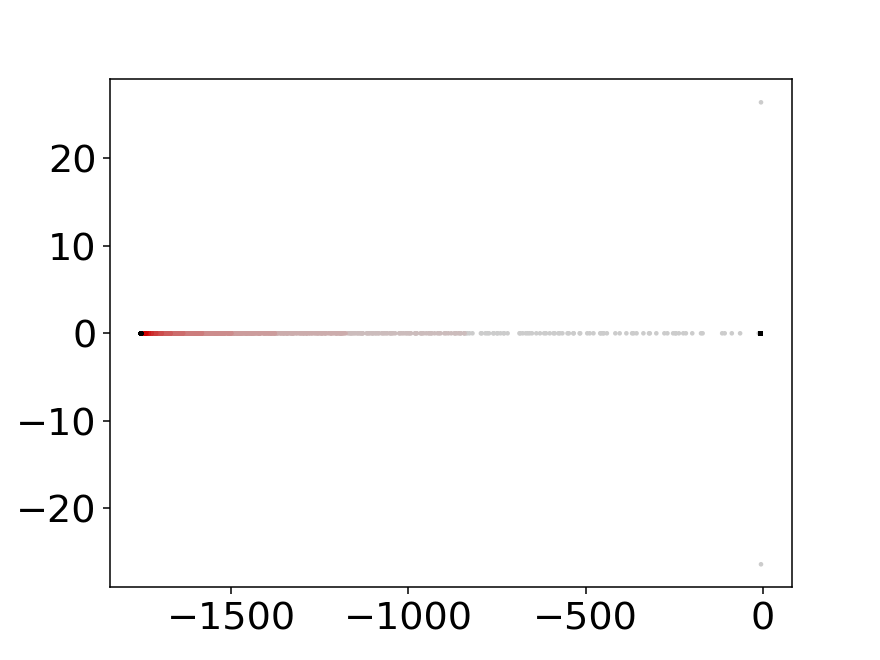

E*=0.0046, I*=0.0778: stable, with nonzero imaginary components


<IPython.core.display.Javascript object>


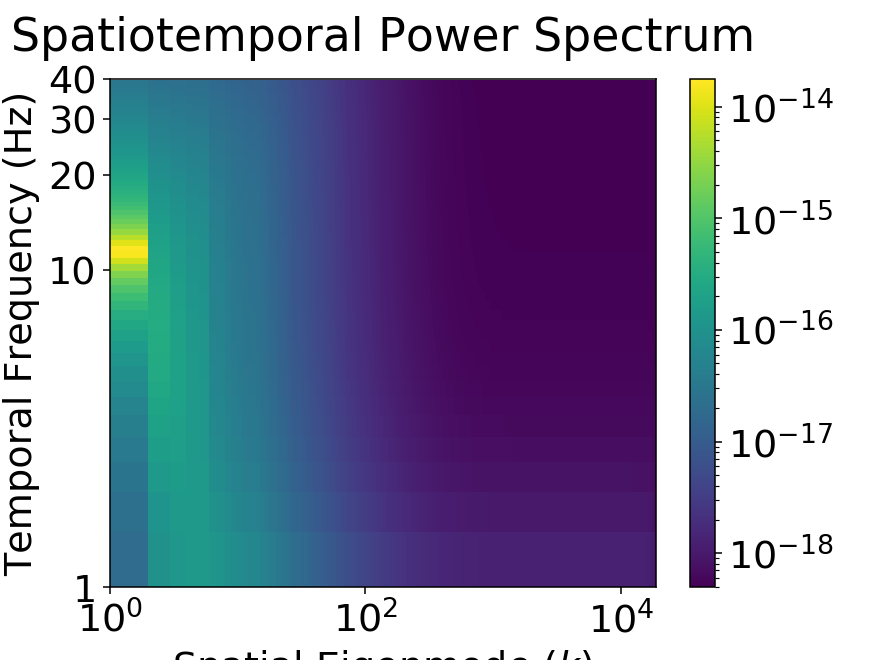

In [54]:
#thesis parameters
#better_result=dict(x=np.array([1.15357519e+02, 1.80816514e+02, 1.89765888e+02, 2.10306805e+02,
#       1.43682388e+01, 1.09130331e+00, 5.36635639e+00, 5.31252166e+00,
#       8.37626732e+00, 2.74681544e+00, 3.66503548e-02, 1.00910684e+02,
#       4.95497870e+00, 4.47579295e+00]))

#re-analyze result of minimization procedure
#better_result=np.load('decent_spatiotemporal_spectrum.npy')[()]

#better_result=np.load('decent_spatiotemporal_spectrum_lower_gauss.npy')[()]

#better_result=np.load('decent_spatiotemporal_spectrum_even_lower_gauss.npy')[()]

#better_result=np.load('decent_spatiotemporal_spectrum_lowest_gauss.npy')[()]

#better_result=np.load('decent_spatiotemporal_spectrum_lower_gauss_no_spatial_peak.npy')[()]

#better_result=np.load('decent_spatiotemporal_spectrum_first_new_realistic_metres.npy')[()]

#better_result=np.load('spatiotemporal_spectrum_empirical_tps.npy')[()]



SStates, success = H_Simple_Steady_State(alpha_EE=better_result['x'][0], alpha_IE=better_result['x'][1], alpha_EI=better_result['x'][2], alpha_II=better_result['x'][3], 
                                         d_e=better_result['x'][4], d_i=better_result['x'][5], P=better_result['x'][6], Q=better_result['x'][7])
print(SStates)       

SSnr=0

SStype, found_suitable, JacEigs = GraphWC_Jacobian_TrDet(Laplacian_eigenvalues=eigenvalues, Graph_Kernel='Gaussian', Ess=SStates[0,SSnr], Iss=SStates[1,SSnr],
                                     alpha_EE=better_result['x'][0], alpha_IE=better_result['x'][1], alpha_EI=better_result['x'][2], alpha_II=better_result['x'][3], d_e=better_result['x'][4], d_i=better_result['x'][5], 
                                     sigma_EE=better_result['x'][8], sigma_IE=better_result['x'][9], sigma_EI=better_result['x'][10], sigma_II=better_result['x'][11],  
                                     D=1, tau_e=better_result['x'][12], tau_i=better_result['x'][13], Visual=True)    


Spectrum = Graph_WC_Spatiotemporal_PowerSpectrum(Laplacian_eigenvalues=eigenvalues, Graph_Kernel='Gaussian', Ess=SStates[0,SSnr], Iss=SStates[1,SSnr],
                                        alpha_EE=better_result['x'][0], alpha_IE=better_result['x'][1], alpha_EI=better_result['x'][2], alpha_II=better_result['x'][3], d_e=better_result['x'][4], d_i=better_result['x'][5], 
                                        sigma_EE=better_result['x'][8], sigma_IE=better_result['x'][9], sigma_EI=better_result['x'][10], sigma_II=better_result['x'][11],  
                                        D=1, tau_e=better_result['x'][12], tau_i=better_result['x'][13],
                                        sigma_noise_e=0.0000001, sigma_noise_i=0.0000001,
                                        min_omega=Min_omega, max_omega=Max_omega, delta_omega=Delta_omega,
                                        Spatial_Spectrum_Only=False, Visual=True)

Spectrum_spatial_only = Graph_WC_Spatiotemporal_PowerSpectrum(Laplacian_eigenvalues=eigenvalues, Graph_Kernel='Gaussian', Ess=SStates[0,SSnr], Iss=SStates[1,SSnr],
                                        alpha_EE=better_result['x'][0], alpha_IE=better_result['x'][1], alpha_EI=better_result['x'][2], alpha_II=better_result['x'][3], d_e=better_result['x'][4], d_i=better_result['x'][5], 
                                        sigma_EE=better_result['x'][8], sigma_IE=better_result['x'][9], sigma_EI=better_result['x'][10], sigma_II=better_result['x'][11],  
                                        D=1, tau_e=better_result['x'][12], tau_i=better_result['x'][13],
                                        sigma_noise_e=0.0000001, sigma_noise_i=0.0000001,
                                        min_omega=Min_omega, max_omega=Max_omega, delta_omega=Delta_omega,
                                        Spatial_Spectrum_Only=True, Visual=False)


#import plotly.graph_objs as go
#from plotly.offline import init_notebook_mode, plot
#init_notebook_mode(connected=True)

#data = [go.Surface(
#                                x=np.arange(1,len(eigenvalues)+1),
#                                y=freqs,
#                                z=Spectrum.T
#                                )
#                ]

#layout = go.Layout(scene=dict(
#    xaxis=dict(
#        type='log',
#        autorange=True
#    ),
#    yaxis=dict(
#        type='log',
#        autorange=True
#    ),
#    zaxis=dict(
#        type='log',
#        autorange=True
#    ))
#)
#fig_ly = go.Figure(data=data, layout=layout)
#plot(fig_ly,filename='E:\whatever.html')



<IPython.core.display.Javascript object>


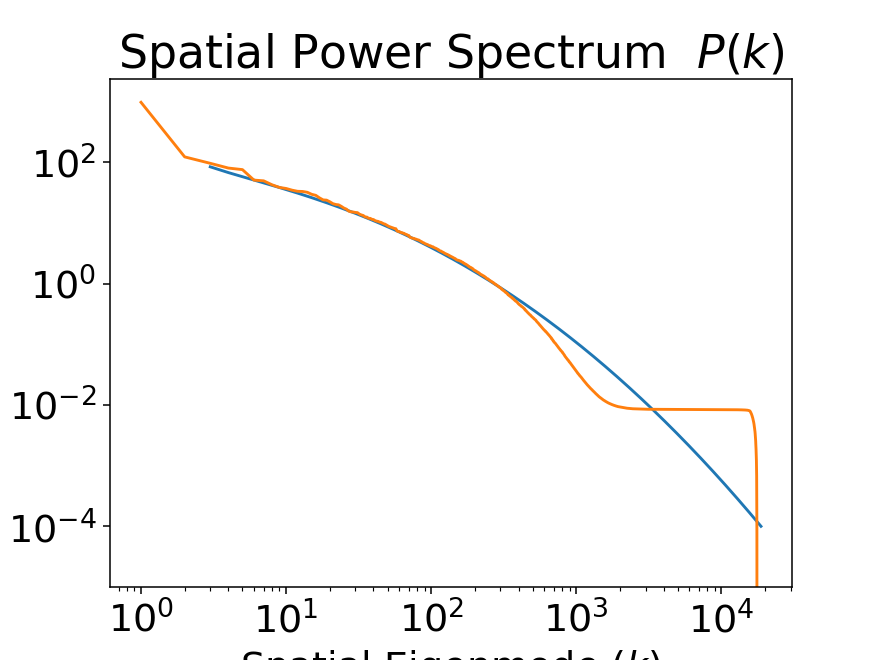

spatial scale factors: 1.1315715516996896e+16 -5.044226044024247
spatial distance: 13.974681271927752
4.426221666814677e-16
-0.03563952433997564


<IPython.core.display.Javascript object>


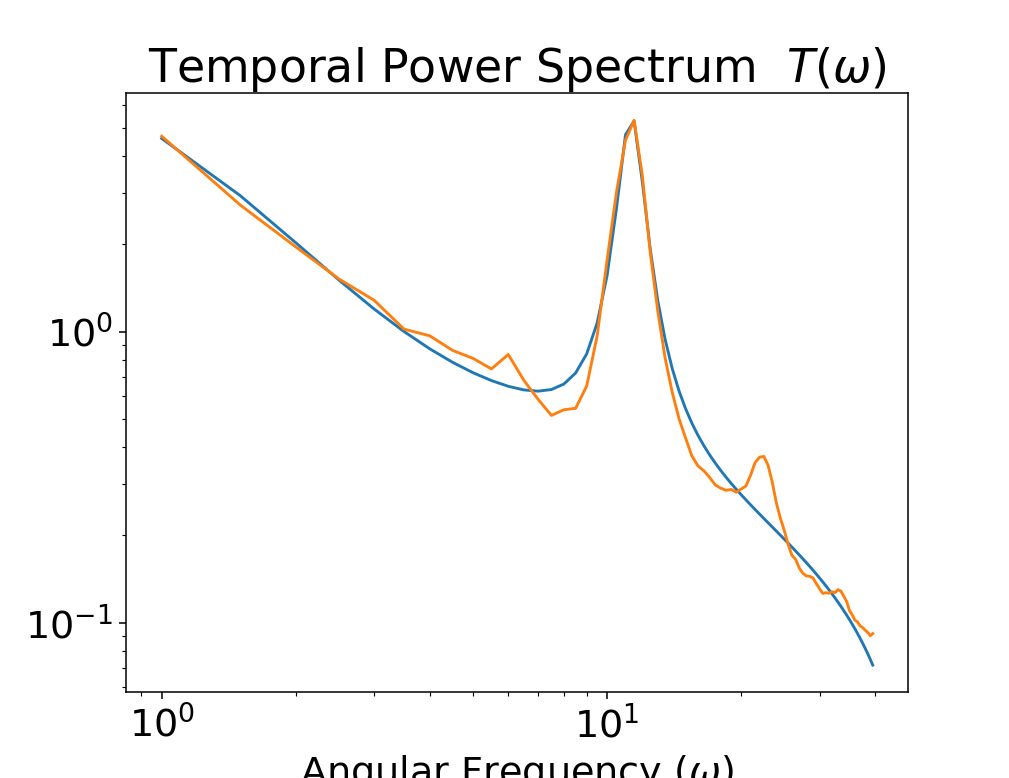

temporal scale factor: 140369507452567.64 -2.705066938488144
temporal distance: 0.8207313757161583
Ks_2sampResult(statistic=0.6711201368106028, pvalue=0.0)
Ks_2sampResult(statistic=0.10256410256410253, pvalue=0.7848117041997917)


In [55]:
Gk=Spectrum_spatial_only[:,0,0] #Delta_omega*np.sum(Spectrum,axis=0)/np.pi
Gw=2*np.sum(Spectrum,axis=1)
plt.ion()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Spatial Power Spectrum  $P(k)$")
ax.set_xlabel("Spatial Eigenmode ($k$)")
true_SPS=True_Spatial_Spectrum

n_spatial = len(true_SPS)
current_spatial_spectrum = Gk[first_k:last_k]
a_spatial = (n_spatial*np.dot(current_spatial_spectrum,true_SPS)-np.sum(true_SPS)*np.sum(current_spatial_spectrum))/(n_spatial*np.dot(current_spatial_spectrum,current_spatial_spectrum)-np.sum(current_spatial_spectrum)**2)
b_spatial = (np.sum(true_SPS)-a_spatial*np.sum(current_spatial_spectrum))/n_spatial
this_spatial_distance = np.linalg.norm(true_SPS - a_spatial*current_spatial_spectrum-b_spatial, ord=2)

print("spatial scale factors: {} {}".format(a_spatial, b_spatial))

print("spatial distance: {}".format(this_spatial_distance))

ax.loglog(np.arange(first_k, last_k), true_SPS)
ax.loglog(np.arange(1,len(eigenvalues)+1), (Gk*a_spatial+b_spatial))

print(Gk[-1])
print((Gk*a_spatial+b_spatial)[-1])

fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_title("Temporal Power Spectrum  $T(\omega)$")
ax.set_xlabel("Angular Frequency ($\omega$)")

freqs=np.arange(Min_omega,Max_omega,Delta_omega)/(2*np.pi)

true_TPS = True_Temporal_Spectrum
n_temporal = len(true_TPS)
current_temporal_spectrum = Gw
a_temporal = (n_temporal*np.dot(current_temporal_spectrum,true_TPS)-np.sum(true_TPS)*np.sum(current_temporal_spectrum))/(n_temporal*np.dot(current_temporal_spectrum,current_temporal_spectrum)-np.sum(current_temporal_spectrum)**2)
b_temporal = (np.sum(true_TPS)-a_temporal*np.sum(current_temporal_spectrum))/n_temporal
           
print("temporal scale factor: {} {}".format(a_temporal, b_temporal))
this_temporal_distance=np.linalg.norm(true_TPS-a_temporal*current_temporal_spectrum-b_temporal, ord=2)
print("temporal distance: {}".format(this_temporal_distance))

#print(np.corrcoef(true_TPS, current_temporal_spectrum))
#print(np.corrcoef(true_SPS, current_spatial_spectrum))


print(sp.stats.ks_2samp(true_SPS, current_spatial_spectrum*a_spatial+b_spatial))
print(sp.stats.ks_2samp(true_TPS, current_temporal_spectrum*a_temporal +b_temporal))

ax.loglog(freqs,
            current_temporal_spectrum*a_temporal +b_temporal)
ax.loglog(freqs, 
            true_TPS)

#np.save('decent_spatiotemporal_spectrum.npy', better_result)
#print(better_result)


In [31]:
#np.load('decent_spatiotemporal_spectrum_lower_gauss.npy')[()]['x']-better_result['x']

np.save('spatiotemporal_spectrum_empirical_tps.npy', better_result)
better_result['x']

array([6.14144881e+02, 8.75561319e+01, 3.48054403e+02, 1.13329236e+02,
       1.40954893e+02, 1.12674348e+01, 4.60142822e+00, 9.19988817e+00,
       7.94085906e-03, 2.73061779e-05, 4.50365827e-02, 5.01922488e-02,
       7.93753452e-02, 1.86637602e+00])

In [ ]:
#comparison of numerical (nonlinear) simulations and (linearized) semi analytic results 
#(any parameter set; grid laplacian only):
#
#1) test for steady state calculation: simulate (with no noise) on a grid, start directly from SS solution.
#2) test for stability/instability/oscillations: add noise in the grid simulation for specific parameter sets
#3) test for power spectrum calculation: run noisy grid simulation and compare prediction with measured PS (see handwritten notes)
#
################################################################################################
#testing the correctness of the parameter fit procedure(full analysis + minimization algorithm) result
#(intended mainly for the better_result parameter set)
#
#retest minimization algorithm, with objective the current best-fit PS obtained and random initial condition. see if other parameter combinations give the same, ideally converge to same par. set
#
#check (via effect on linearized Jk eigenvalues) if a nearby hopf bifurcation can be induced by changing P or some other parameter 
#(to ask rikkert: do we want this as a prior requirement in minimization? would be hard but doable)
#

In [ ]:
#1D predictions
#set up 1D-specific simulation parameters and WCM propagators
one_dim=False
syn=1
#if making plot from connectome minimization, need to change this value to the number of connectome nodes
gridsize=1000#len(eigenvalues)
h=0.0002
Min_omega=5*(2*np.pi)
Max_omega=50*(2*np.pi)
Delta_omega=0.1*(2*np.pi)

Graph_Kernel='Gaussian'
one_dim_eigenvalues, one_dim_eigenvectors = one_dim_Laplacian_eigenvalues(gridsize, h, syn, vecs=True)
#one_dim_eigenvalues2 = one_dim_Laplacian_eigenvalues(gridsize, h, syn)

#re-analyze result of minimization procedure
#better_result=np.load('decent_spatiotemporal_spectrum.npy')[()]

#better_result=np.load('decent_spatiotemporal_spectrum_lower_gauss.npy')[()]

#better_result=np.load('decent_spatiotemporal_spectrum_even_lower_gauss.npy')[()]

#better_result=np.load('decent_spatiotemporal_spectrum_lowest_gauss.npy')[()]

#thesis result
#better_result=dict(x=np.array([1.15357519e+02, 1.80816514e+02, 1.89765888e+02, 2.10306805e+02,
#       1.43682388e+01, 1.09130331e+00, 5.36635639e+00, 5.31252166e+00,
#       8.37626732e+00, 2.74681544e+00, 3.66503548e-02, 1.00910684e+02,
#       4.95497870e+00, 4.47579295e+00]))

aEE=better_result['x'][0]
aIE=better_result['x'][1]
aEI=better_result['x'][2]
aII=better_result['x'][3]
dE=better_result['x'][4]
dI=better_result['x'][5]
P=better_result['x'][6]
Q=better_result['x'][7]
sEE=better_result['x'][8]
sIE=better_result['x'][9]
sEI=better_result['x'][10]
sII=better_result['x'][11]
D=1
tE=better_result['x'][12]
tI=better_result['x'][13]
snE=0.0000001
#snE=0.0001
snI=snE

#given parameters, calculate steady states
steady_states, success = H_Simple_Steady_State(aEE, aIE, aEI, aII, dE, dI, P, Q)


#for each steady state, compute linear stability and power spectrum
if success==True:
    nrSS=len(steady_states[0])
    allG = np.empty((nrSS,int((Max_omega-Min_omega)/Delta_omega),gridsize), dtype=float)
    SStypes=np.zeros(nrSS)
    for ss in range(nrSS):

        Ess = steady_states[0,ss]
        Iss = steady_states[1,ss]

        SStypes[ss], found_suitable, JacEigs = GraphWC_Jacobian_TrDet(one_dim_eigenvalues, Graph_Kernel, Ess, Iss,
                                         alpha_EE=aEE, alpha_IE=aIE, alpha_EI=aEI, alpha_II=aII, d_e=dE, d_i=dI,
                                         sigma_EE=sEE, sigma_IE=sIE, sigma_EI=sEI, sigma_II=sII, D=D, 
                                         tau_e=tE, tau_i=tI, Visual=True) 

        #allG[ss,:,:] = 
        allG[ss,:,:] =Graph_WC_Spatiotemporal_PowerSpectrum(one_dim_eigenvalues, Graph_Kernel, Ess, Iss,
                                                aEE, aIE, aEI, aII, dE, dI,
                                                 sEE, sIE, sEI, sII, D, 
                                                 tE, tI,
                                                 snE, snI, 
                                                  Min_omega, Max_omega, Delta_omega,          
                                                   Spatial_Spectrum_Only=False, Visual=True)
        
        sspectrum =Graph_WC_Spatiotemporal_PowerSpectrum(one_dim_eigenvalues, Graph_Kernel, Ess, Iss,
                                                aEE, aIE, aEI, aII, dE, dI,
                                                 sEE, sIE, sEI, sII, D, 
                                                 tE, tI,
                                                 snE, snI,         
                                                   Spatial_Spectrum_Only=True, Visual=True)
        

        
        Func_Conn_prediction = Functional_Connectivity(one_dim_eigenvectors, sspectrum[:,0,0], one_dim=True, Visual=True)
        

        

In [ ]:
#1D grid simulation (nonlinear wilson-cowan)
#thesis values
#Time=100
#Delta_t=0.01

#more recent param set values
#Time=3
#Delta_t=0.0001

#duration and timestep (new realistic)
Time=10
Delta_t=0.00005

#parameters of 1D graph (nonlocal synapses, grid size, grid spacing)
#syn=150
#gridsize=1000
#h=1

nrSS=0
Ess = steady_states[0,nrSS]
Iss = steady_states[1,nrSS]    


E_total= Graph_Wilson_Cowan_Model(Ess, Iss, Time, Delta_t,                          
                         aEE, aIE, aEI, aII,
                         sEE, sIE, sEI, sII, D,
                         dE, dI, P, Q, tE, tI, snE, snI, Graph_Kernel,                                  
                         one_dim=True, syn=syn, gridsize=gridsize, h=h,
                         Visual=False, SaveActivity=False, Filepath=' ')   


In [ ]:
#activity analysis and comparison with prediction
#thesis values
#Max_omega=50
#Delta_omega=0.1

Min_omega=1*(2*np.pi)
Max_omega=100*(2*np.pi)

PS, TPS, FC = Activity_Analysis(Ess, Iss, Delta_t, 
                            aEE, aIE, aEI, aII,
                            sEE, sIE, sEI, sII, D,
                            dE, dI, P, Q, tE, tI, snE, snI, Graph_Kernel,                             
                            beta=False, E_total=E_total,                                                      
                            prediction=True, min_omega=Min_omega, max_omega=Max_omega, delta_omega=Delta_omega,                        
                            one_dim=True, syn=syn, gridsize=gridsize, h=h,                           
                            Visual=True, Save_Results=False, Filepath=' ')


In [ ]:
#Human connectome simulation (linearized wilson-cowan: perturbation about steady state)
#thesis time and timestep values
#Time=100
#Delta_t=0.01

Time=2
Delta_t=0.0001

nrSS=0
Ess = steady_states[0,nrSS]
Iss = steady_states[1,nrSS]  


Beta_E_total = Linearized_GLDomain_Wilson_Cowan_Model(Ess, Iss, Time, Delta_t,                          
                         aEE, aIE, aEI, aII,
                         sEE, sIE, sEI, sII, D,
                         dE, dI, P, Q, tE, tI, snE, snI, Graph_Kernel,
                         one_dim=False, eigvals=eigenvalues, eigvecs=None,
                         Visual=False, SaveActivity=False, Filepath=' ') 



In [ ]:
#activity analysis of linearized model and comparison with prediction (perturbation about steady state)
#thesis values
#Max_omega=50
#Delta_omega=0.1

#Max_omega=2000
#Delta_omega=1

PS_full, TPS_full = Activity_Analysis(Ess, Iss, Delta_t,
                                   aEE, aIE, aEI, aII,
                                   sEE, sIE, sEI, sII, D,
                                   dE, dI, P, Q, tE, tI, snE, snI, Graph_Kernel,
                                
                                   beta=True, beta_E_total=Beta_E_total,
                                   
                                   prediction=True, min_omega=Min_omega, max_omega=Max_omega, delta_omega=Delta_omega,
                                      
                                 #  Spatial_scaling=[a_spatial,b_spatial], Temporal_scaling=[a_temporal,b_temporal],
                                   
                                   one_dim=False, syn=syn, gridsize=gridsize, h=h,
                                      
                                   eigvals=eigenvalues, eigvecs=None,
                                   
                                   Visual=True, Save_Results=False, Filepath=' ')




In [ ]:
##########################################################################################################

In [ ]:
#further verification: 1D grid simulation (linearized wilson-cowan: perturbation about steady state)

#duration and timestep
Time=3
Delta_t=0.00001

#parameters of 1D graph (nonlocal synapses, grid size, grid spacing)
syn=150
gridsize=1000
h=1

nrSS=0
Ess = steady_states[0,nrSS]
Iss = steady_states[1,nrSS]   



Beta_E_total_1D = Linearized_GLDomain_Wilson_Cowan_Model(Ess, Iss, Time, Delta_t,                          
                         aEE, aIE, aEI, aII,
                         sEE, sIE, sEI, sII, D,
                         dE, dI, P, Q, tE, tI, snE, snI, Graph_Kernel,
                         one_dim=True, syn=syn, gridsize=gridsize, h=h,
                         eigvals=None, eigvecs=None,
                         Visual=False, SaveActivity=False, Filepath=' ') 



In [ ]:
#activity analysis of linearized model and comparison with prediction (perturbation about steady state)
#thesis values
#Max_omega=50
#Delta_omega=0.1
plt.close('all')
Max_omega=3000
Delta_omega=0.5

PS_full_1D, TPS_full_1D = Activity_Analysis(Ess, Iss, Delta_t,
                                   aEE, aIE, aEI, aII,
                                   sEE, sIE, sEI, sII, D,
                                   dE, dI, P, Q, tE, tI, snE, snI, Graph_Kernel,
                                
                                   beta=True, beta_E_total=Beta_E_total_1D,
                                   
                                   prediction=True, max_omega=Max_omega, delta_omega=Delta_omega,
                                   
                                   one_dim=True, syn=syn, gridsize=gridsize, h=h,
                                      
                                   eigvals=None, eigvecs=None,
                                   
                                   Visual=True, Save_Results=False, Filepath=' ')


In [ ]:
#MISC
#Beta_E_total=np.load('G:/Macbook Stuff/Simulation Results/Decent spatiotemporal spectrum activity.npy')
#del Beta_E_total
#del eigenvectors
#del connectome_activity
#np.save('G:/Macbook Stuff/Simulation Results/Decent spatiotemporal spectrum activity.npy', Beta_E_total)
#print(len(Beta_E_total[0]))
#print(Beta_E_total[0])
with h5py.File("G:/Macbook Stuff/Simulation Results/Decent spatiotemporal spectrum activity.h5") as hf:
    if "Activity" not in list(hf.keys()):
        #connectome_activity=np.dot(eigenvectors,Beta_E_total)
        hf.create_dataset("Activity",  data=connectome_activity)
    else:
        print("Warning: overwriting results of a previous simulation.") 

In [ ]:
#################******** PROPAGATOR TESTS ********#################

In [ ]:
#propagator test 1
#damped wave/telegrapher parameters
#params for first working tests: a=0.3, b=0.001, c=0, Delta_t=1, h=1 (worked with 2-normalized eigenvalues)
#make a smaller: wave travels faster
a=0.3
#make b larger: more diffusion
b=0.001
#nonzero c: switch from damped wave to telegrapher eqn
c=0

gridsize=1000
syn=0
h=1
u_0=0.3*sp.signal.gaussian(gridsize, 10)#np.zeros(gridsize)#(-0.1/499**2)*(np.arange(gridsize)-499)**2 + 0.1 
Delta_t=1
Time=100
#u_0[499]=1
u_final=graph_propagator_test(u_0, Time, Delta_t, kernel_param=Delta_t, Graph_Kernel='Damped Wave', a=a, b=b, c=c, sigma_noise=0.0,
                          one_dim=True, syn=syn, gridsize=gridsize,  h=h, eigvals=None, eigvecs=None,                         
                          Visual=True, SaveActivity=False, Filepath=' ', NSim=0)

In [ ]:
#propagator test 2
gridsize=1000
syn=0
h=1
u_0=np.zeros(gridsize)#(-0.1/499**2)*(np.arange(gridsize)-499)**2 + 0.1 
Delta_t=1
Time=Delta_t
u_0[499]=400
#u_0=np.ones(gridsize)
u_final=graph_propagator_test(u_0, Time, Delta_t, kernel_param=Delta_t, Graph_Kernel='Gaussian', sigma_noise=0,
                          one_dim=True, syn=syn, gridsize=gridsize,  h=h, eigvals=None, eigvecs=None,                         
                          Visual=True, SaveActivity=False, Filepath=' ', NSim=0)
np.sum(u_final)

In [ ]:
#proptest 3 cortical mesh convolutions

u_0=np.zeros(len(eigenvalues))#np.zeros(gridsize)#(-0.1/499**2)*(np.arange(gridsize)-499)**2 + 0.1 
u_0[6369]=50
u_prop=graph_propagator_test(u_0, Time=50, Delta_t=50, kernel_param=50/1000000, Graph_Kernel='Gaussian', sigma_noise=0.0,
                          one_dim=False, syn=0, gridsize=0,  h=0, eigvals=eigenvalues, eigvecs=eigenvectors,                         
                          Visual=False, SaveActivity=False, Filepath=' ', NSim=0)

In [ ]:
#propagator test 4: cortical mesh
##NOTE: THESE PARAMETERS WERE FOR THE EIGENVALUES OF THE LAPLACIAN IN MILLIMIETERS
#damped wave/telegrapher parameters
#params for first working tests: a=0.3, b=0.001, c=0, Delta_t=1
#make a smaller: wave travels faster
a=0.3
#make b larger: more diffusion
b=0.005
#nonzero c: switch from damped wave to telegrapher eqn
c=0

#in metres it should be enough to do (also change initial gaussian kernel param)
a*=1000000
b*=1000000


u_0=np.zeros(len(eigenvalues))#np.zeros(gridsize)#(-0.1/499**2)*(np.arange(gridsize)-499)**2 + 0.1 
Delta_t=1
Time=10
u_0[6369]=50

#gauss kernel parm 50/1000000


u_1=graph_propagator_test(np.dot(eigenvectors.T,u_0), Time=2, Delta_t=1, kernel_param=1, 
                          Graph_Kernel='Pyramid', sigma_noise=0.0,
                          one_dim=False, syn=0, gridsize=0,  h=0, eigvals=eigenvalues, GF_domain=True,                         
                          Visual=False, SaveActivity=False, Filepath=' ', NSim=0)
u_total=graph_propagator_test(u_1[:,1], Time, Delta_t, kernel_param=Delta_t, Graph_Kernel='Damped Wave', a=a, b=b, c=c, sigma_noise=0.0,
                          one_dim=False, syn=0, gridsize=0,  h=0, eigvals=eigenvalues, GF_domain=True,                       
                          Visual=False, SaveActivity=True, Filepath=' ', NSim=0)
u_total=np.dot(eigenvectors,u_total)

In [ ]:
#propagator test 5 stochastic damped wave in fourier domain for quantitative spectrum calculation

#make a smaller: wave travels faster
#make b larger: more diffusion

#nonzero c: switch from damped wave to telegrapher eqn
c=0


a=0.3*1000000
b=0.05*1000000
sigma_noise=0.0001


beta_0=np.ones(len(eigenvalues))#np.zeros(gridsize)#(-0.1/499**2)*(np.arange(gridsize)-499)**2 + 0.1 
Delta_t=1
Time=200

dw_beta_act=graph_propagator_test(np.dot(eigenvectors.T, beta_0), Time, Delta_t, kernel_param=Delta_t, Graph_Kernel='Damped Wave', a=a, b=b, c=c,
                                 sigma_noise=sigma_noise,
                                 one_dim=False, syn=0, gridsize=0,  h=0, GF_domain=True, eigvals=eigenvalues,                          
                                 Visual=False, SaveActivity=False, Filepath=' ', NSim=0)


#dw_PS_pred

In [ ]:
#dw_beta_act = np.load('G:\Macbook Stuff\Simulation Results\Damped Wave Kernel Test t=1\0# Sim Activity.h5')
dw_PS = np.var(dw_beta_act, axis=1)
dw_TPS = sp.signal.periodogram(dw_beta_act, fs=1/Delta_t, detrend='constant', scaling='density')
f = plt.figure()
plt.plot(dw_PS)
f2 = plt.figure()
plt.plot(dw_TPS[0]*(2*np.pi),np.sum(dw_TPS[1], axis=0))

In [ ]:
a=10000
b=50000000
sigma_noise=0.001

lambdas, omegas = np.meshgrid(eigenvalues, dw_TPS[0][1:]*(2*np.pi))
prediction = sigma_noise**2 / (b**2 * omegas**2 + (lambdas - a*omegas**2)**2)

#f3 = plt.figure()
#ax = f3.add_subplot(111)
#pc = ax.pcolormesh(lambdas, omegas, prediction)
#f3.colorbar(pc)

f4 = plt.figure()
plt.plot(dw_TPS[0][1]*np.sum(prediction, axis=0)/np.pi)
f5 = plt.figure()
plt.plot(dw_TPS[0][1:]*(2*np.pi), 2*np.sum(prediction, axis=1))


In [ ]:
import plotly.plotly as py
import plotly.graph_objs as go
f = h5py.File('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/100307_Laplace.mat', 'r')
CC = np.asarray(f['CC']['restInds'], dtype=int)
indices = np.array([elem[0] for elem in CC])-1
AllVet=np.asarray(f['vertices']['all'])
AllVet=AllVet[:,indices]

dist=np.sqrt(AllVet[0,:]**2 + AllVet[1,:]**2 + AllVet[2,:]**2)
trace4 = go.Scatter3d(
    x=AllVet[0,:],
    y=AllVet[1,:],
    z=AllVet[2,:],
    #alphahull=50
    mode='markers',
    marker=dict(
        size=5,
        color=dist,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=1,
        #line=dict(color='rgba(0, 0, 0,0.5)',width=1,)
        )
    )
data = [trace3]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [ ]:
with h5py.File('G:/Macbook Stuff/Simulation Results/Damped Wave Kernel Test t=1/0# Sim Activity b=0.005.h5', 'r') as file:
    print(list(file.keys()))
    DWave = np.asarray(file['Activity'], dtype=float)

DWave[:,0]

In [ ]:
#beta_u_total=np.load('G:/Macbook Stuff/Simulation Results/new realistic activity.npy')#np.dot(eigenvectors, dw_beta_act)
#u_total=np.dot(eigenvectors,beta_u_total)
#del beta_u_total
#del eigenvectors
#covariance = np.cov(u_total)
#del u_total
#FC=np.dot(np.diag(np.power(np.diag(covariance),-0.5)),np.dot(covariance,np.diag(np.power(np.diag(covariance),-0.5))))    
#del covariance

plt.close('all')
fig=plt.figure()
ax = fig.add_subplot(111)
im = ax.imshow(FC, vmax=0.1, vmin=-0.1)
fig.colorbar(im)

In [ ]:
Func_Conn_prediction = Functional_Connectivity(eigenvectors, Spectrum_spatial_only[:,0,0], one_dim=False, Visual=True)

In [ ]:
#np.save('G:/Macbook Stuff/Simulation Results/FC new realistic', FC)
#np.save('G:/Macbook Stuff/Simulation Results/new realistic activity', u_total)

In [ ]:
import plotly.offline as offline
from plotly.graph_objs import *
#init_notebook_mode(connected=True)
offline.init_notebook_mode()

#mesh (or full connectome) graph edges
#trace1=Scatter3d(x=Xe,
#               y=Ye,
#               z=Ze,
#               mode='lines',
#              line=Line(color='rgba(0,0,0,1)', width=1),
#             )

#Mesh3d
trace2=Mesh3d(x=Xn,
               y=Yn,
               z=Zn,
              i=iN,
              j=jN,
              k=kN,
              text=np.arange(len(Xn)),
           #   intensity=DWave[:,0],
             lighting = dict(ambient=1, diffuse=0.1, roughness = 0.9, specular=1.8, fresnel=0.01),
              cmin=-10E-9,#-0.1,#-10E-9,#-0.1,
              cmax=10E-9#0.1#10E-9#0.1
              #eigenvectors[:,1001]#
              
            
              
          #     mode='markers',
          #  marker=dict(
          #          size=5,
          #          color=-AllVet[1,:],#np.sqrt(AllVet[2,:]**2+AllVet[0,:]**2+AllVet[1,:]**2),                # set color to an array/list of desired values
          #          colorscale='Viridis',   # choose a colorscale
          #          opacity=0.8,
          #          line=dict(color='rgba(0, 0, 0,0.5)',
          #                     width=1,
        #                     )
        #                )
                )



interval = 1000
max_time = 2000#11* interval


frames =[dict(data=[dict(type='mesh3d', 
                         #HERE IS WHAT DECIDES THE COLOR-TIMEPLOT
                         intensity=np.zeros(len(Xn)))],#u_total[:,i])],
                  traces=[0],
                  name='{}'.format(i)) for i in range(0,max_time,interval)] 






axis=dict(showbackground=False,
          showline=False,
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title=''
          )
                 
layout = Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ),
    scene=dict(
             xaxis=dict(axis),
             yaxis=dict(axis),
             zaxis=dict(axis),
        ),  
    hovermode=False,     autosize=False,
    width=1000,
    height=1150
)       
data=[trace2]

fig_frames = Figure(data=data, layout=layout, frames=frames)

fig_frames['layout']['updatemenus'] = [
    {
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 120, 'redraw': True},
                         'fromcurrent': True, 'transition': {'duration': 120, 'easing': 'quadratic-in-out'}}],
                'label': 'Play',
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate',
                'transition': {'duration': 0}}], 
                'label': 'Pause',
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': True,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }
]



fig_frames['layout']['sliders'] = [{
    'active': 0,
    'yanchor': 'top',
    'xanchor': 'left',
    'currentvalue': {
        'font': {'size': 20},
        'prefix': 'time=',
        'visible': True,
        'xanchor': 'right'
    },
    'transition': {'duration': 120, 'easing': 'cubic-in-out'},
    'pad': {'b': 10, 't': 5},
    'len': 0.9,
    'x': 0.1,
    'y': 0,
    'steps': [{
    'method': 'animate',
    'label': '{}'.format(i),
   # 'value': '',
    'args': [[i], {'frame': {'duration': 300, 'redraw': True},
         'mode': 'immediate'}
    ],
} for i in range(0,max_time,interval)]
}]



#fig=Figure(data=data, layout=layout)

offline.iplot(fig_frames, filename='Les-Miserables')

In [ ]:
with h5py.File('G:/Macbook Stuff/Downloads/Fibers.mat', 'r') as file:
    print(list(file.keys()))
    print(list(file['fgCC'].keys()))
        
    Fibers=[file[element][:] for element in file['fgCC']['fibers'][0]]

fiber_edges=np.load('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fgCC_fiber_edges.npy')
f = h5py.File('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/100307_Laplace.mat', 'r')
CC = np.asarray(f['CC']['restInds'], dtype=int)
f.close()
indices = np.array([elem[0] for elem in CC])-1
EX=[]
EY=[]
EZ=[]
colors=[]

counter=0
for i in range(0,len(Fibers),2):
    if fiber_edges[i,0] in indices and fiber_edges[i,1] in indices and fiber_edges[i,0]!=fiber_edges[i,1]:
        counter+=1
        for j in range(Fibers[i].shape[0]-1):
            EX+=[Fibers[i][j,0], Fibers[i][j+1,0], None]
            EY+=[Fibers[i][j,1], Fibers[i][j+1,1], None]
            EZ+=[Fibers[i][j,2], Fibers[i][j+1,2], None]

counter    


    

In [ ]:
fig_frames.write_image("G:/fig1.png")

In [ ]:
import plotly.offline as offline
from plotly.graph_objs import *
#init_notebook_mode(connected=True)
offline.init_notebook_mode()

trace3=Scatter3d(x=EX,
               y=EY,
               z=EZ,
               mode='lines',
               line=Line(color=EX,#'rgba(100,100,100,0.9)',#colors
                         #colorscale=[[0, 'rgb(0,0,255)'], [1, 'rgb(255,0,0)']],#'Rainbow',
                         width=1),
               )
axis=dict(showbackground=False,
          showline=False,
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title=''
          )
                 
layout = Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ),
    scene=dict(
             xaxis=dict(axis),
             yaxis=dict(axis),
             zaxis=dict(axis),
        ),
    hovermode=False
)       
data=Data([trace3])
fig=Figure(data=data, layout=layout)

offline.iplot(fig, filename='Les-Miserables-2')